   1. bookID
   2. title
   3. authors
   4. average_rating
   5. isbn
   6. isbn13
   7. language_code
   8.   num_pages
   9. ratings_count
  10. text_reviews_count
  11. publication_date
  12. publisher

 Первые 5 строк:
   bookID                                              title                     authors  average_rating        isbn         isbn13 language_code    num_pages  ratings_count  text_reviews_count publication_date        publisher
0       1  Harry Potter and the Half-Blood Prince (Harry ...  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969           eng          652        2095690               27591        9/16/2006  Scholastic Inc.
1       2  Harry Potter and the Order of the Phoenix (Har...  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071           eng          870        2153167               29221         9/1/2004  Scholastic Inc.
2       4  Harry Potter and the Chamber of Secrets (Harry...                J.K. Rowling    

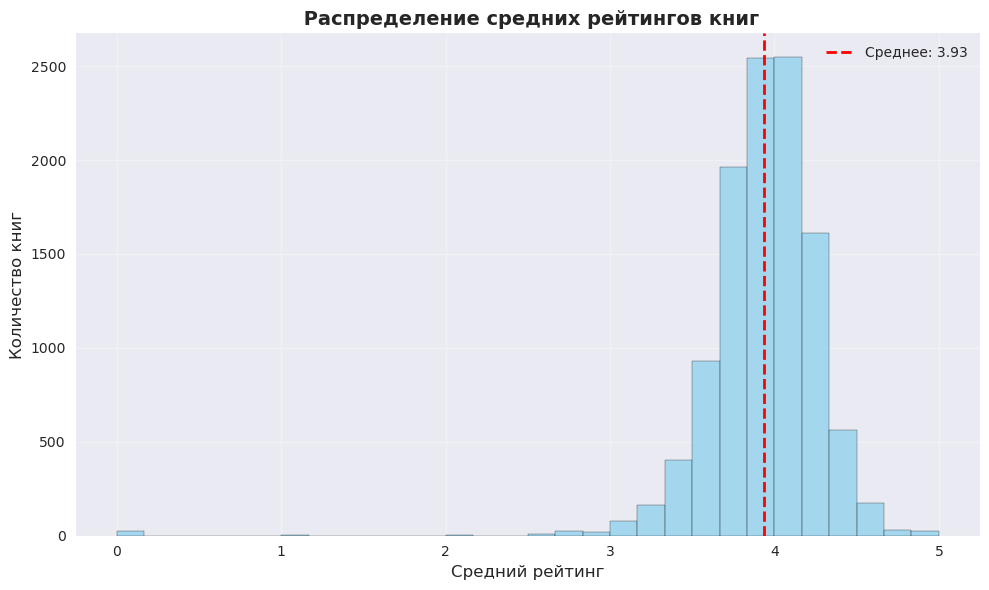

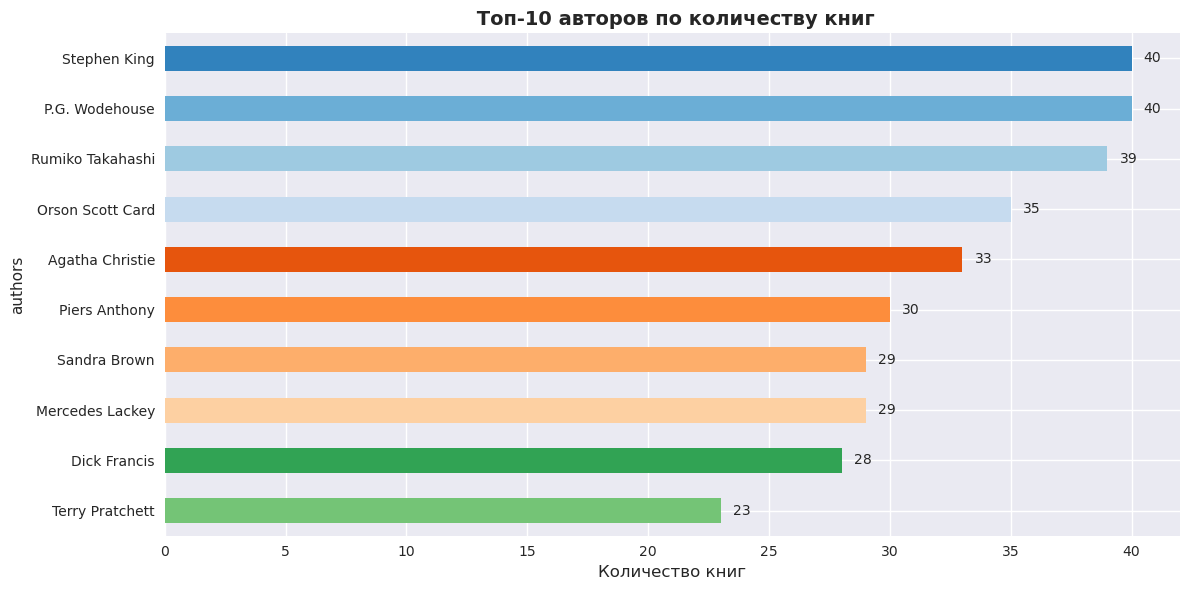

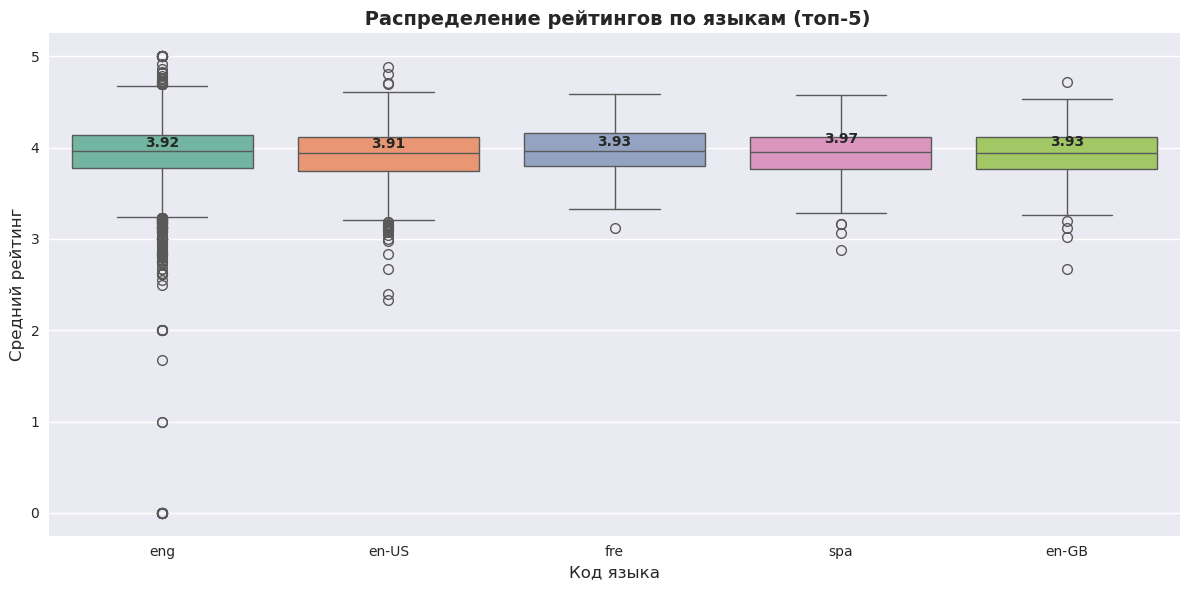

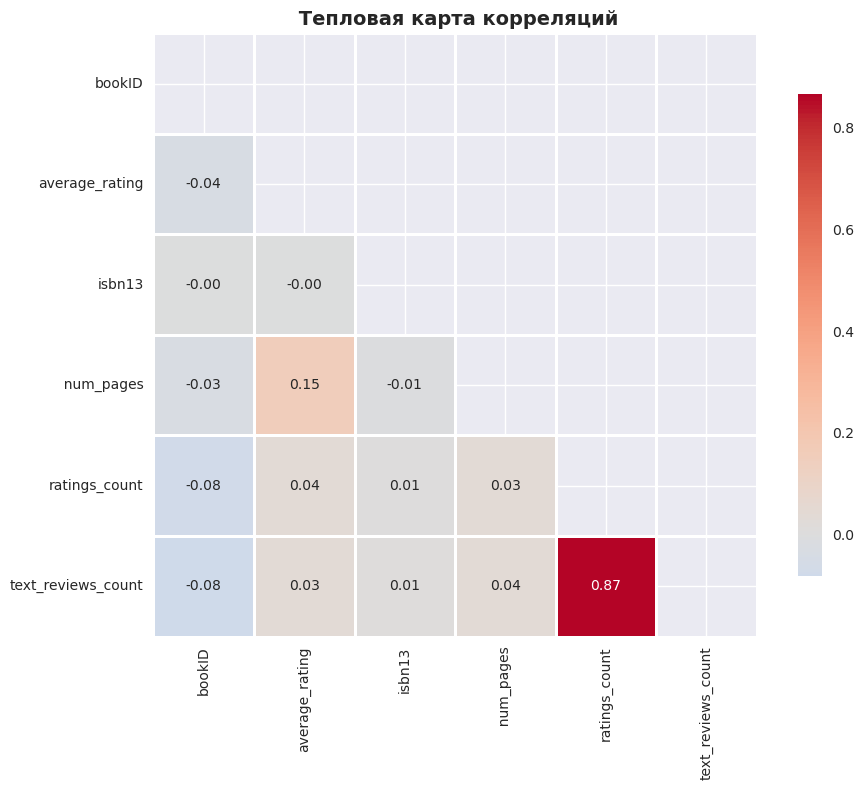

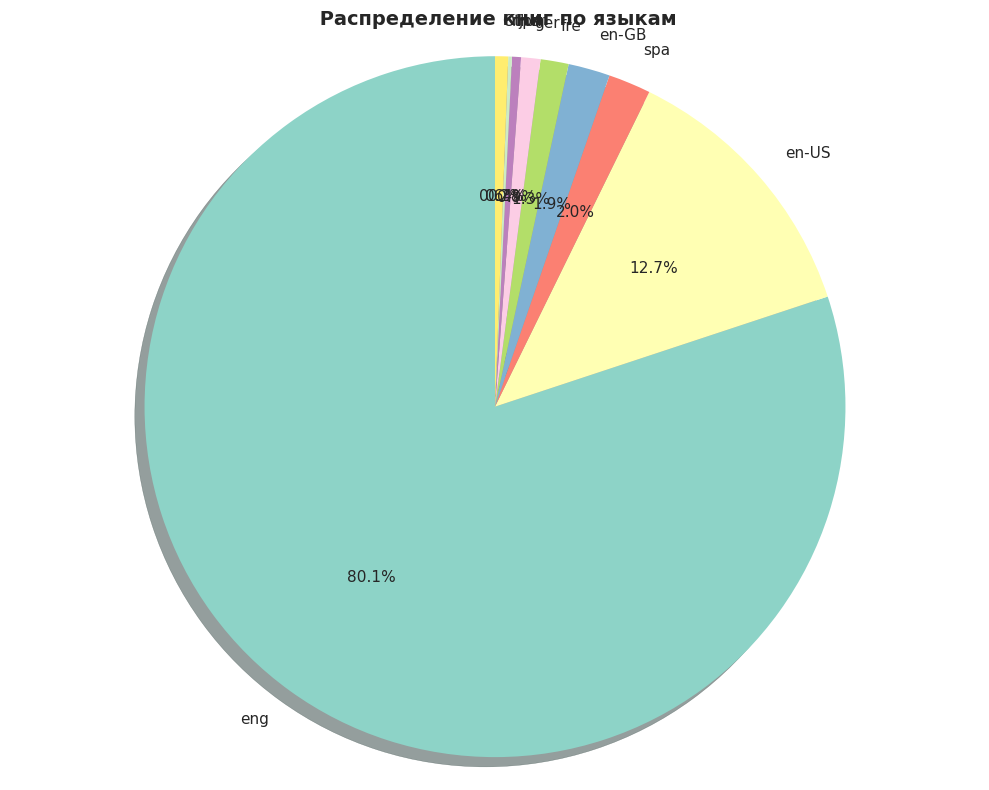


 ТОП-10 АВТОРОВ ПО СРЕДНЕМУ РЕЙТИНГУ (минимум 5 книг):
                               Средний_рейтинг  Количество_книг  Лучшая_книга
authors                                                                      
Bill Watterson                            4.71                7          4.82
Hiromu Arakawa/Akira Watanabe             4.57               12          4.60
Hiromu Arakawa/荒川弘/方郁仁                    4.56                8          4.60
Hiromu Arakawa                            4.55                5          4.57
J.K. Rowling/Mary GrandPré                4.55                6          4.78
J.K. Rowling                              4.51               11          4.73
Karen Kingsbury/Gary Smalley              4.44                5          4.50
Hirohiko Araki/Hirohiko Araki             4.40                7          4.45
J.R.R. Tolkien                            4.40               17          4.59
Karen Kingsbury                           4.39                8          4.49

 СТАТИС

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

try:
    # Загрузка из интернета
    url = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv'
    df = pd.read_csv(url)
except:
    df = pd.read_csv('books.csv', on_bad_lines='skip')

for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")



# Просмотр первых строк
print("\n Первые 5 строк:")
print(df.head())

# Информация о типах данных
print("\n Информация о данных:")
print(df.info())

# Пропущенные значения
print("\n ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Колонка': missing.index,
    'Пропущено': missing.values,
    'Процент': missing_percent.values
})
print(missing_df[missing_df['Пропущено'] > 0])

# Обработка пропусков (только для существующих колонок)
print("\n ОБРАБОТКА ПРОПУСКОВ")
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            # Для числовых - медиана
            df[col] = df[col].fillna(df[col].median())
        else:
            # Для текстовых - мода (самое частое значение)
            if df[col].mode().empty:
                df[col] = df[col].fillna('Unknown')
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
        print(f"  ✓ {col}: заполнено {df[col].isnull().sum()} пропусков")

# Дубликаты
print(f"\n ДУБЛИКАТЫ: {df.duplicated().sum()}")


# 2. СТАТИСТИЧЕСКИЙ АНАЛИЗ


print(df.describe())

# Уникальные значения
print("\n кол-во уникальных значений по столбцам:")
for col in df.select_dtypes(include=['object']).columns:
    unique_count = df[col].nunique()
    print(f"  {col}: {unique_count} уникальных значений")

# Корреляционный анализ (только числовые колонки)
print("\n")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    # Убираем диагональ (корреляция с самой собой = 1)
    idx = corr_pairs.index
    top_corr = corr_pairs[(idx.get_level_values(0) != idx.get_level_values(1))].head(5)
    for (col1, col2), value in top_corr.items():
        print(f"  {col1} ↔ {col2}: {value:.3f}")
# 3. ВИЗУАЛИЗАЦИИ

if 'average_rating' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df['average_rating'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title(' Распределение средних рейтингов книг', fontsize=14, fontweight='bold')
    plt.xlabel('Средний рейтинг', fontsize=12)
    plt.ylabel('Количество книг', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axvline(df['average_rating'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Среднее: {df["average_rating"].mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# График 2: Топ-10 авторов (если есть колонка authors)
if 'authors' in df.columns:
    plt.figure(figsize=(12, 6))
    top_authors = df['authors'].value_counts().head(10)
    colors = plt.cm.tab20c(np.arange(len(top_authors)))
    top_authors.plot(kind='barh', color=colors)
    plt.title(' Топ-10 авторов по количеству книг', fontsize=14, fontweight='bold')
    plt.xlabel('Количество книг', fontsize=12)
    plt.gca().invert_yaxis()
    # Добавляем значения на столбцы
    for i, v in enumerate(top_authors.values):
        plt.text(v + 0.5, i, str(v), va='center')
    plt.tight_layout()
    plt.show()

# График 3: Количество книг по годам (если есть колонка original_publication_year)
if 'original_publication_year' in df.columns:
    plt.figure(figsize=(12, 6))
    # Очищаем данные: убираем нереальные годы
    df_year = df[(df['original_publication_year'] > 1900) & (df['original_publication_year'] < 2023)]
    books_per_year = df_year['original_publication_year'].value_counts().sort_index()
    
    plt.plot(books_per_year.index, books_per_year.values, 
             marker='o', linestyle='-', linewidth=2, markersize=4, color='green')
    plt.title(' Количество книг по годам публикации', fontsize=14, fontweight='bold')
    plt.xlabel('Год публикации', fontsize=12)
    plt.ylabel('Количество книг', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# График 4: Boxplot рейтингов по языкам (если есть language_code)
if 'language_code' in df.columns and 'average_rating' in df.columns:
    plt.figure(figsize=(12, 6))
    # Берем только топ-5 языков
    top_languages = df['language_code'].value_counts().head(5).index
    df_top_lang = df[df['language_code'].isin(top_languages)]
    
    sns.boxplot(x='language_code', y='average_rating', data=df_top_lang, palette='Set2')
    plt.title(' Распределение рейтингов по языкам (топ-5)', fontsize=14, fontweight='bold')
    plt.xlabel('Код языка', fontsize=12)
    plt.ylabel('Средний рейтинг', fontsize=12)
    # Добавляем средние значения
    means = df_top_lang.groupby('language_code')['average_rating'].mean()
    for i, (lang, mean_val) in enumerate(means.items()):
        plt.text(i, mean_val + 0.05, f'{mean_val:.2f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    plt.tight_layout()
    plt.show()

# График 5: Heatmap корреляций
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=1, 
                cbar_kws={"shrink": 0.8}, fmt='.2f')
    plt.title(' Тепловая карта корреляций', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# График 6: Круговая диаграмма языков
if 'language_code' in df.columns:
    plt.figure(figsize=(10, 8))
    lang_counts = df['language_code'].value_counts().head(8)
    other_count = df['language_code'].value_counts().tail(len(df['language_code'].value_counts()) - 8).sum()
    
    if other_count > 0:
        lang_counts['Other'] = other_count
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(lang_counts)))
    plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%',
            startangle=90, shadow=True, colors=colors, textprops={'fontsize': 11})
    plt.title(' Распределение книг по языкам', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# 4. ГРУППИРОВКИ И АГРЕГАЦИИ


# Группировка 1: Средний рейтинг по авторам
if 'authors' in df.columns and 'average_rating' in df.columns:
    print("\n ТОП-10 АВТОРОВ ПО СРЕДНЕМУ РЕЙТИНГУ (минимум 5 книг):")
    author_stats = df.groupby('authors').agg(
        Средний_рейтинг=('average_rating', 'mean'),
        Количество_книг=('average_rating', 'count'),
        Лучшая_книга=('average_rating', 'max')
    ).round(2)
    
    author_stats = author_stats[author_stats['Количество_книг'] >= 5]
    top_authors_rating = author_stats.nlargest(10, 'Средний_рейтинг')
    print(top_authors_rating)

# Группировка 2: Количество книг по годам
if 'original_publication_year' in df.columns:
    print("\n ТОП-10 ЛЕТ ПО КОЛИЧЕСТВУ ВЫПУЩЕННЫХ КНИГ:")
    df_year = df[(df['original_publication_year'] > 1900) & (df['original_publication_year'] < 2023)]
    year_counts = df_year['original_publication_year'].value_counts().head(10)
    print(year_counts)

# Группировка 3: Статистика по издательствам (если есть publisher)
if 'publisher' in df.columns and 'average_rating' in df.columns:
    print("\n СТАТИСТИКА ПО ИЗДАТЕЛЬСТВАМ (топ-10):")
    publisher_stats = df.groupby('publisher').agg({
        'average_rating': ['mean', 'count'],
        'title': lambda x: x.iloc[0] if not x.empty else ''
    }).round(2)
    
    publisher_stats.columns = ['Средний_рейтинг', 'Количество_книг', 'Пример_книги']
    top_publishers = publisher_stats.nlargest(10, 'Количество_книг')
    print(top_publishers)

# Группировка 4: Средний рейтинг по языкам
if 'language_code' in df.columns and 'average_rating' in df.columns:
    print("\n СРЕДНИЙ РЕЙТИНГ ПО ЯЗЫКАМ:")
    lang_rating = df.groupby('language_code')['average_rating'].agg(['mean', 'count']).round(3)
    lang_rating = lang_rating[lang_rating['count'] >= 10]  # только языки с 10+ книгами
    print(lang_rating.sort_values('mean', ascending=False).head(10))


# 5. ВЫВОДЫ И РЕЗУЛЬТАТЫ


conclusions = []

if 'average_rating' in df.columns:
    conclusions.append(f"Средний рейтинг всех книг: {df['average_rating'].mean():.2f}")
    conclusions.append(f"Максимальный рейтинг: {df['average_rating'].max():.2f}")
    conclusions.append(f"Минимальный рейтинг: {df['average_rating'].min():.2f}")

if 'authors' in df.columns:
    top_author = df['authors'].value_counts().index[0]
    author_count = df['authors'].value_counts().iloc[0]
    conclusions.append(f"Самый продуктивный автор: {top_author} ({author_count} книг)")
    conclusions.append(f"Всего уникальных авторов: {df['authors'].nunique()}")

if 'original_publication_year' in df.columns:
    df_year = df[(df['original_publication_year'] > 1900) & (df['original_publication_year'] < 2023)]
    if not df_year.empty:
        peak_year = df_year['original_publication_year'].value_counts().index[0]
        peak_count = df_year['original_publication_year'].value_counts().iloc[0]
        conclusions.append(f"Пик публикаций: {int(peak_year)} год ({peak_count} книг)")

if 'language_code' in df.columns:
    top_lang = df['language_code'].value_counts().index[0]
    top_lang_count = df['language_code'].value_counts().iloc[0]
    conclusions.append(f"Самый популярный язык: {top_lang} ({top_lang_count} книг)")
    conclusions.append(f"Всего языков: {df['language_code'].nunique()}")

# Выводим выводы
print("\n ОСНОВНЫЕ ВЫВОДЫ:")
for i, conclusion in enumerate(conclusions, 1):
    print(f"{i}. {conclusion}")


try:
    df.to_csv('processed_books.csv', index=False, encoding='utf-8')
    print("\n Обработанные данные сохранены в 'processed_books.csv'")
except Exception as e:
    print(f"\n Не удалось сохранить файл: {e}")
    

In [10]:
%pip install seaborn